In [ ]:
#IMPORTING DIFFERENT LIBRARIES NEEDED
import numpy as np
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential,load_model
from keras.layers import Dense,LSTM,Dropout, Activation, Masking
from keras.regularizers import l2
from keras import callbacks
from keras.callbacks import History, ModelCheckpoint, EarlyStopping

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
#These are Padded inputs i.e there are three layers of zeros between every spectrogram.
#Padding can be avoided but there are no cons.
#These are already is the required shape (x*100*252 for CQT and x*100*88 for labels)
xtrain=np.load("/content/gdrive/My Drive/totalCQT3.npy")
ytrain=np.load("/content/gdrive/My Drive/totallabel3.npy")
xtest=np.load("/content/gdrive/My Drive/totalCQT4.npy")
ytest=np.load("/content/gdrive/My Drive/totallabel4.npy")

In [ ]:
#We can also do it in another method using Many inputs and one Output Technique.
#For this we have to import data in raw form in shapes (x*252 and x*88).
#
######RUN THIS ONLY IF USING SECOND METHOD#######
#
j=0;
y2train=[]
for i in range(50,1540851,100):
    y2train.append(ytrain[i,:])
    j=j+1
y2train=np.array(y2train)

j=0;
y2test=[]
for i in range(50,507251,100):
    y2test.append(ytest[i,:])
    j=j+1
y2test=np.array(y2test)

# max_shape = (xtrain.shape[0]//100)*100
# xtrain= np.reshape(xtrain[0:max_shape,:],(xtrain.shape[0]//100 ,100,xtrain.shape[1]))
# max_shape = (ytrain.shape[0]//100)*100
# ytrain= ytrain[0:max_shape,:]
# max_shape = (xtest.shape[0]//100)*100
# xtest= np.reshape(xtest[0:max_shape,:],(xtest.shape[0]//100,100,xtest.shape[1]))
# max_shape = (ytest.shape[0]//100)*100
# ytest= ytest[0:max_shape,:]
# ytrain=np.reshape(ytrain,(ytrain.shape[0]//100,100,88))
# ytest=np.reshape(ytest,(ytest.shape[0]//100,100,88))

In [ ]:
#CONSTRUCTING A SEQUENTIAL MODEL WITH 2 HIDDEN LAYERS. ALL ARE LSTM LAYERS WITH DROPOUTS. 
#IF USING SECOND METHOD THEN MODIFY THE RETURN SEQUENCES OF LAST LSTM LAYER.
rnn=Sequential()
rnn.add(LSTM(units=256,return_sequences=True,input_shape=(xtrain.shape[1],252),activation='tanh'))
rnn.add(Dropout(0.25))
rnn.add(LSTM(units=256,return_sequences=True,activation='tanh'))
rnn.add(Dropout(0.25))
rnn.add(LSTM(units=256,return_sequences=True,activation='tanh'))
rnn.add(Dropout(0.25))
rnn.add(Dense(units=88,activation='sigmoid'))

In [ ]:
#Compiling the model with binary crossentropy since we want ouputs in binary form.
rnn.compile(optimizer='adam',loss='binary_crossentropy')

In [ ]:
#RUN THIS IF YOU WANT TO SAVE YOUR WEIGHTS TO A LOCATION AND THEN MODIFY THE FIT ACCORDINGLY.
checkpointer = ModelCheckpoint(filepath="weights (2).hdf5", verbose=1, save_best_only=False)

In [ ]:
#To Get the Summary of the model
rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 256)          521216    
_________________________________________________________________
dropout (Dropout)            (None, 100, 256)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 256)          525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 256)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 256)          525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 256)          0         
_________________________________________________________________
dense (Dense)                (None, 100, 88)           2

In [ ]:
#TO AVOID OVERFITTING USE EarlyStopping
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

In [ ]:
#FIT THE MODEL. Modify Batch Size According to the Processor used or According to your Aim.
rnn.fit(xtrain,ytrain,epochs=50,verbose=1,validation_data=(xtest,ytest),callbacks=[early],batch_size=10)

Epoch 1/50
1585/1585 [==============================] - 184s 100ms/step - loss: 0.1802 - val_loss: 0.1164
Epoch 2/50
1585/1585 [==============================] - 155s 98ms/step - loss: 0.1065 - val_loss: 0.1058
Epoch 3/50
1585/1585 [==============================] - 155s 98ms/step - loss: 0.0904 - val_loss: 0.0980
Epoch 4/50
1585/1585 [==============================] - 155s 98ms/step - loss: 0.0804 - val_loss: 0.0951
Epoch 5/50
1585/1585 [==============================] - 155s 98ms/step - loss: 0.0735 - val_loss: 0.0935
Epoch 6/50
1585/1585 [==============================] - 155s 98ms/step - loss: 0.0690 - val_loss: 0.0935
Epoch 7/50
1585/1585 [==============================] - 157s 99ms/step - loss: 0.0640 - val_loss: 0.0904
Epoch 8/50
1585/1585 [==============================] - 156s 99ms/step - loss: 0.0605 - val_loss: 0.0893
Epoch 9/50
1585/1585 [==============================] - 156s 98ms/step - loss: 0.0578 - val_loss: 0.0896
Epoch 10/50
1585/1585 [==============================]

In [ ]:
#Load Test Data.
#Since I have used my validation and Test data as Same for Training, I have Just assigned another variable.
xtest1=xtest
ytest1=ytest

In [ ]:
#Here TP Stands for True Positive, FP stand for False Positive , FN stands for False Negative.
#We Do not consider TN since in music most of the data is TN and hence it is not logical to include TN.
TP = 0
FP = 0
FN = 0
rnn_predictions = rnn.predict(xtest1, batch_size=10, verbose = 1) 
#Now reshape Predictions back to 2D form.
rnn_predictions = np.reshape(rnn_predictions,(ytest1.shape[0]*ytest1.shape[1],ytest1.shape[2]))
#Reshape Labels Back to 2D form.
ytest1 = np.reshape(ytest1,(ytest1.shape[0]*ytest1.shape[1],ytest1.shape[2]))
#Round the values since we only want Binary Ouput.
rnn_predictions = np.array(rnn_predictions).round()
#Convert all the values greater than 1 to 1.
rnn_predictions[rnn_predictions > 1] = 1

504/504 [==============================] - 23s 43ms/step


In [ ]:
def outputmetrics(rnn_predictions,ytest1):
    TP = np.count_nonzero(np.logical_and( rnn_predictions == 1, ytest1 == 1 ))
    FN = np.count_nonzero(np.logical_and( rnn_predictions == 0, ytest1 == 1 ))
    FP = np.count_nonzero(np.logical_and( rnn_predictions == 1, ytest1 == 0 ))
    if (TP) > 0:
        Sensitivity = TP/float(TP + FN)
        #Also called Recall
        Precision = TP/float(TP + FP)
        Accuracy = 100*TP/float(TP + FP + FN)
        F=100*2*Precision*Sensitivity/(Precision + Sensitivity)
    else: 
        Accuracy=0
        F=0
        Sensitivity=0
        Precision=0
    
    print('\n F-measure pre-processed: ')
    print(F)
    print('\n Accuracy pre-processed: ')
    print(Accuracy)
    print('\n Sensitivity pre-processed: ')
    print(Sensitivity*100)
    print('\n Precision pre-processed: ')
    print(Precision*100)

    

In [ ]:

outputmetrics(rnn_predictions,ytest1)    
# print('\n F-measure pre-processed: ')
# print(F)
# print('\n Accuracy pre-processed: ')
# print(Accuracy)
# print('\n Sensitivity pre-processed: ')
# print(Sensitivity)
# print('\n Precision pre-processed: ')
# print(Precision)


#F measure is Harmonic Mean of Precision and Sensitivity. Since our Data in Highly Imbalanced towards TN,
#F measure is a better alternative to accuracy""".



 F-measure pre-processed: 
67.88389246813959

 Accuracy pre-processed: 
51.38199553129362

 Sensitivity pre-processed: 
61.41361327046675

 Precision pre-processed: 
75.87808766407974


In [ ]:
import matplotlib.pyplot as plt


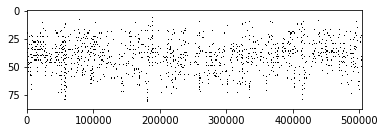

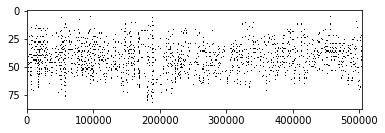

In [ ]:
# PLOTTING TO SEE THE VISIBLE DIFFERENCES. 
#PLOTTING BEFORE CLEANING

plt.figure()
plt.subplot(211)
plt.imshow(rnn_predictions.transpose(),cmap='Greys',aspect='auto',interpolation='nearest')
plt.figure()
plt.subplot(212)
plt.imshow(ytest1.transpose(),cmap='Greys',aspect='auto',interpolation='nearest')
plt.show()

In [ ]:
#NOW WE CLEAN THE MODEL. THIS STEP IS NOT NECESSARY AND TAKES A LOT OF TIME SINCE THERE WILL BE A LOT OF ITERATIONS.
#SINCE OUR TIME FRAME IS SMALL WE CONSIDER LIMITS OF HUMAN CAPABILITY IN MODIFYING SOME OUTPUTS.

for a in range(rnn_predictions.shape[1]):
    for j in range(2,rnn_predictions.shape[0]-3):
        if rnn_predictions[j-1,a] == 1 and rnn_predictions[j,a] == 0 and rnn_predictions[j+1,a] == 0 and rnn_predictions[j+2,a] == 1:
            rnn_predictions[j,a] = 1
            rnn_predictions[j+1,a] = 1
        if rnn_predictions[j-2,a] == 0 and rnn_predictions[j-1,a] == 0 and rnn_predictions[j,a] == 1 and rnn_predictions[j+1,a] == 1 and rnn_predictions[j+2,a] == 0 and rnn_predictions[j+3,a] == 0:
            rnn_predictions[j,a] = 0
            rnn_predictions[j+1,a] = 0
        if rnn_predictions[j-1,a] == 0 and rnn_predictions[j,a] == 1 and rnn_predictions[j+1,a] == 0 and rnn_predictions[j+2,a] == 0:
            rnn_predictions[j,a] = 0
        if rnn_predictions[j-1,a] == 1 and rnn_predictions[j,a] == 0 and rnn_predictions[j+1,a] == 1 and rnn_predictions[j+2,a] == 1:
            rnn_predictions[j,a] = 1

In [ ]:
outputmetrics(rnn_predictions,ytest1)    
## print('\n F-measure pre-processed: ')
## print(F)
## print('\n Accuracy pre-processed: ')
## print(Accuracy)

# '''F measure is Harmonic Mean of Precision and Sensitivity. Since our Data in Highly Imbalanced towards TN,
#    F measure is a better alternative to accuracy'''.
# '''IN THIS THE F MEASURE VALUE AND ACCURACY WILL INCREASE BY NEGLIGIBLE AMOUNTS BUT THIS WILL LEAD TO NOTICEABLE CHANGES
#    IN PIANO ROLL REPRESENTATION'''


 F-measure pre-processed: 
68.1454822114611

 Accuracy pre-processed: 
51.68232636575193

 Sensitivity pre-processed: 
61.21104743657073

 Precision pre-processed: 
76.85181774762204


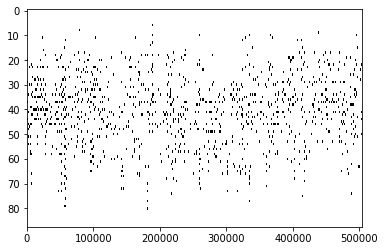

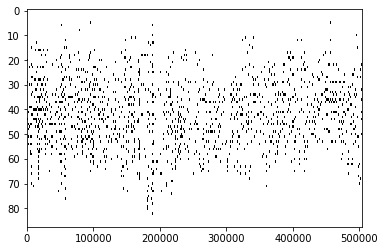

In [ ]:
# PLOTTING TO SEE THE VISIBLE DIFFERENCES. 

plt.figure()
plt.plot
plt.imshow(rnn_predictions.transpose(),cmap='Greys',aspect='auto',interpolation='nearest')
plt.show()
plt.figure()
plt.plot
plt.imshow(ytest1.transpose(),cmap='Greys',aspect='auto',interpolation='nearest')
plt.show()